# Train ranking model with user representation
 - In the following notebook we will train [DCN model](https://www.tensorflow.org/recommenders/examples/dcn)
 - Model performance will be evaluate via the following metrics:
   - [novelty](https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff):
 $\large\frac{\sum_{u}^{U} \sum_{l}^{L_u} \frac{- log(P_{l})}{|L_u|}}{|U|}$, where $U$ is a set of all users and $L_u$ is a list of recommended arcicles for a user $u$
   - [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

In [ ]:
!pip install git+https://github.com/seznam/MLPrague-2022.git tensorflow-recommenders==0.5.2 tensorflow-io==0.25.0

In [ ]:
# mount google drive
from mlprague22.util import mount_gdrive
BASE_DIR, IN_COLAB = mount_gdrive("mlprague2022")

In [ ]:
# import necessary functionality
import gc
import os

from collections import Counter, OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io.arrow as arrow_io
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow_io.python.ops.arrow_dataset_ops import arrow_schema_to_tensor_types

import pandas as pd
import pyarrow as pa
import numpy as np

import sklearn.metrics as metrics

from itertools import zip_longest

from mlprague22.evaluation import evaluate, sample_users, sample_items

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 8_192
EPOCHS = 10

OUTPUT_DIR = os.path.join(BASE_DIR, "data/mind_cold_start_datasets_basic/")
# input data
COLD_START_BEHAVIORS_TRAIN = os.path.join(OUTPUT_DIR, "behaviors_train.tsv")
COLD_START_BEHAVIORS_TEST = os.path.join(OUTPUT_DIR, "behaviors_test.tsv")
NEWS_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "news_catalogue_train.tsv")
NEWS_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "news_catalogue_test.tsv")
AUXILIARY_DATA_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_train.tsv")
AUXILIARY_DATA_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_test.tsv")
ALL_CATEGORIES_PATH = os.path.join(OUTPUT_DIR, "categories.tsv")
ALL_SUBCATEGORIES_PATH = os.path.join(OUTPUT_DIR, "subcategories.tsv")
# train, test, sampled users
TRAIN_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "train_ex_df.feather")
TEST_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "test_no_item_coldstart_ex_df.feather")
SAMPLED_USERS_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "sampled_users_df.feather")
# user embedding
EMBEDDINGS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "embeddings")
FT_HISTORY_EMBEDDINGS_TRAIN = "ft_histories_train.vec"
FT_HISTORY_EMBEDDINGS_TEST = "ft_histories_test.vec"
EMBEDDINGS_OUTPUT_TRAIN = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TRAIN)
EMBEDDINGS_OUTPUT_TEST = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TEST)

MODEL_DIR = os.path.join(BASE_DIR, "models")

In [ ]:
# load training/evaluation data
CATEGORIES = (
    pd.read_csv(ALL_CATEGORIES_PATH, sep="\t").sort_values("order").category.tolist()
)
# note: subcategories will be used in TASK 1
SUBCATEGORIES = (
    pd.read_csv(ALL_SUBCATEGORIES_PATH, sep="\t").sort_values("order").subcategory.tolist()
)
behaviors_train = pd.read_csv(COLD_START_BEHAVIORS_TRAIN, sep="\t")
behaviors_test = pd.read_csv(COLD_START_BEHAVIORS_TEST, sep="\t")
news_train = pd.read_csv(NEWS_CATALOGUE_TRAIN, sep="\t")
ft_histories_user_vectors_train = np.loadtxt(EMBEDDINGS_OUTPUT_TRAIN, delimiter=",")
ft_histories_user_vectors_test = np.loadtxt(EMBEDDINGS_OUTPUT_TEST, delimiter=",")

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
def set_seed(seed=RANDOM_SEED):
    import random
    import numpy as np
    import tensorflow as tf

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
# in order to make this notebook at least partially reproducible set seed of the most common randomness sources
set_seed()

### Load training/eval data
 - Recommender system usualy presents users with slate level recommendation:

 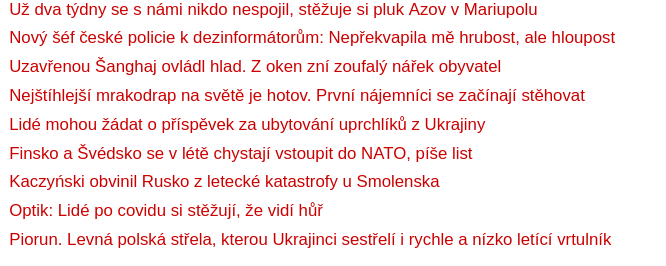


 - But ranking models are trained on single item recommendation and user direct feeedback - all instances on which user clicked are positive instances and those without click are negative
 - Therefore one needs to transform dataset into a format in which each row will match single item recommendation and user feedback
 - We will prepare training and testing dataset and save them in csv format, which can be easily loaded into [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
def prepare_dataset(input_path, output_path, emb_vecs, overwrite=False):
    if os.path.exists(output_path) and not overwrite:
        return

    behaviors = pd.read_csv(input_path, sep="\t")

    e_df = (
        behaviors[
            [
                "userid",
                "slateid",
                "history",
                "impressions",
                "history_all_categories",
                "history_all_subcategories",
            ]
        ]
        .assign(
            impression_arr=lambda x: x.impressions.map(
                lambda ii: [i.split("-") for i in ii.split(" ")]
            )
        )
        .drop(columns="impressions")
        .assign(user_embedding=lambda x: [e for e in emb_vecs.astype(np.float32)])
        .explode("impression_arr")
        .assign(impression=lambda x: x.impression_arr.map(lambda xx: xx[0]))
        .assign(click=lambda x: x.impression_arr.map(lambda xx: int(xx[1])))
        .drop(columns="impression_arr")
        .assign(history_size=lambda x: x.history.map(lambda xx: len(xx.split())))
    )

    e_df.reset_index(drop=True).to_feather(output_path)

In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TRAIN, TRAIN_DF_OUTPUT_PATH, ft_histories_user_vectors_train)
train_df = pd.read_feather(TRAIN_DF_OUTPUT_PATH)
display(train_df)

In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TEST, TEST_DF_OUTPUT_PATH, ft_histories_user_vectors_test)
test_df = pd.read_feather(TEST_DF_OUTPUT_PATH)
display(test_df)

In [ ]:
def load_dataset(path, df, feat_cols, label_col="click", batch_size=BATCH_SIZE, cache=True):
    column_names = [*feat_cols, label_col] if label_col is not None else feat_cols

    schema = pa.Schema.from_pandas(df)
    columns = [schema.get_field_index(f) for f in column_names]
    types, shapes = arrow_schema_to_tensor_types(schema)
    types = tuple(types[c] for c in columns)
    shapes = tuple(shapes[c] for c in columns)

    def to_named(*args):
        if label_col is not None:
            return ({f: n for f, n in zip(feat_cols, args[:-1])},
                    tf.cast(args[-1], tf.int32))
        else:
            return {f: n for f, n in zip(feat_cols, args)}

    ds = arrow_io.ArrowFeatherDataset(
        [path],
        columns=columns,
        output_types=types,
        output_shapes=shapes,
        batch_size=batch_size
    ).map(to_named)

    if cache:
        ds = ds.cache(f"/tmp/cache-{os.path.basename(path)}")

    return ds

In [ ]:
# create tensorflow training dataset from preparaded data file
# note: "user_embedding" feature will be used in TASK 2
train_data_cached = load_dataset(TRAIN_DF_OUTPUT_PATH, train_df,
                                 ["history", "impression", "history_all_subcategories", "user_embedding"])

In [ ]:
test_data_cached = load_dataset(TEST_DF_OUTPUT_PATH, test_df,
                                ["history", "impression", "history_all_subcategories", "user_embedding"])

In [ ]:
# compute how many mini-batched are within one epoch
# information is used later during training as training data are read infinitely
def batch_count(df, batch_size=BATCH_SIZE):
    return (len(df) + batch_size - 1) // batch_size

In [ ]:
BATCHES_PER_EPOCH = batch_count(train_df)
BATCHES_PER_TEST = batch_count(test_df)

### Create embeddings for string features
 - DCN transforms all input data into embeddings - in order to do that we need to tranform text inputs into integers which can be then transformed into embedding 
 - We will use `tf.keras.layers.experimental.preprocessing.TextVectorization` in newer version of tf one might need to use `tf.keras.layers.TextVectorization` instead

In [ ]:
NEWS_IDS = news_train.newsid.tolist()

In [ ]:
history_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode="int", standardize=None, vocabulary=NEWS_IDS
)

### Create weighted train dataset
 - Dataset suffers from class unbalance as there are not many clicks available
 - We will try to mitigate class unbalance via [class_weight](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights) argument of `fit` methods - which reweights the loss 

In [ ]:
labels, labels_counts = train_label_counts = np.unique(train_df["click"], return_counts=True)

In [ ]:
labels

In [ ]:
labels_counts

In [ ]:
label_weights = {
    l: (1 / l_count) * (labels_counts.sum() / 2.0)
    for l, l_count in zip(labels, labels_counts)
}

In [ ]:
label_weights

## Prepare evaluation data
 - We will evaluate model performance on single item level and on slate level
 - AUC metric will be used for item level evaluation and all data from test dataset will be considered
 - Novelty metric will be used for slate level evaluation and only sample of users and items will be considered, if we were to consider all items and users inference would take too much time
  - Items are sampled with respect to their subcategory so they are evenly represented
  - Users are sampled with respect to their history size so ther are evenly represented

In [ ]:
sampled_users = sample_users(test_df, RANDOM_SEED)
sampled_users.shape

In [ ]:
sampled_items = sample_items(news_train, RANDOM_SEED)
len(sampled_items)

In [ ]:
sampled_users_df = (sampled_users[
    [
         "history_all_categories",
         "history_all_subcategories",
         "history",
         "user_embedding"
    ]
].assign(impression=lambda x: [sampled_items.values]*len(x))
 .explode("impression"))

sampled_users_df.reset_index(drop=True).to_feather(SAMPLED_USERS_DF_OUTPUT_PATH)

sampled_users_data = load_dataset(SAMPLED_USERS_DF_OUTPUT_PATH, sampled_users_df,
                                  ["history", "impression", "history_all_subcategories", "user_embedding"], label_col=None,
                                  batch_size=len(sampled_items))

In [ ]:
def get_user_prediction(user_predictions, per_user_predicted_items=20):
    return np.argpartition(user_predictions, -per_user_predicted_items)[
        -per_user_predicted_items:
    ]

### Define DCN model

In [ ]:
class DCN(tfrs.Model):
    """Implementation of stacked DCN architecture"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__()

        self.model_kwargs = deepcopy(model_kwargs)

        entity_id_embedder = tf.keras.layers.Embedding(
            history_vectorizer.vocabulary_size(), entity_emb_size
        )

        feature_fn = {
            "impression": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.Reshape([entity_emb_size]),
                ]
            ),
            "history": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.GlobalAveragePooling1D(),
                ]
            )
        }

        self._features = features
        self._feature_fn = {key: feature_fn[key] for key in features}
        self._cross_layers = [
            tfrs.layers.dcn.Cross(projection_dim=projection_dim)
            for _ in range(cross_layers)
        ]

        normalization_cls = None
        if normalization == "layer":
            normalization_cls = tf.keras.layers.LayerNormalization
        elif normalization == "batch":
            normalization_cls = tf.keras.layers.BatchNormalization
        elif normalization == "no_normalization":
            pass
        elif normalization:
            raise ValueError(f"Unknown normalization: '{normalization}'")

        self._cross_layers_normalizations = (
            [normalization_cls() for _ in range(cross_layers)]
            if normalization_cls
            else []
        )
        self._deep_layers = [
            tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layers
        ]
        self._deep_layers_normalizations = (
            [normalization_cls() for _ in deep_layers] if normalization_cls else []
        )

        self._sigmoid = tf.keras.layers.Dense(1, activation="sigmoid")

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name="auc", curve="PR"),
                tf.keras.metrics.TruePositives(name="TP"),
                tf.keras.metrics.TrueNegatives(name="TN"),
                tf.keras.metrics.FalsePositives(name="FP"),
                tf.keras.metrics.FalseNegatives(name="FN"),
            ],
        )

    def call(self, data, training=None):
        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x = layer(x0, x)
            if normalization:
                x = normalization(x, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x))

        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            x = layer(x)
            if normalization:
                x = normalization(x, training=training)

        x = self._sigmoid(x)

        return x

    def compute_loss(self, data, training=False):
        # Pick data from generator which yield couples of data and label
        d = data[0]
        labels = data[1]
        sample_weight = data[2] if len(data) == 3 else None
        predictions = self(d, training=training)

        return self.task(
            labels=tf.expand_dims(labels, axis=1),
            predictions=predictions,
            sample_weight=sample_weight,
        )

## Training/evaluation of model
 - train DCN model only on user history and evaluate its performance

In [ ]:
def train(model, name, features):
    """Trains `model` using `features` and calls it using `name`."""
    set_seed()

    train_data = (
        train_data_cached
        .unbatch()
        .shuffle(10000, seed=RANDOM_SEED)
        .repeat()
        .batch(BATCH_SIZE)
    )

    ranking_model = model(
        features=features,
        cross_layers=1,
        deep_layers=[512, 256],
        entity_emb_size=64,
        normalization="batch",
    )

    # hack: turn eager execution on as tf is unable to find lenght of certain dimensions in data
    tf.config.run_functions_eagerly(True)
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

    # hack: load one item for tf to be able to decode dimensions properly
    ranking_model(list(train_data.take(1))[0][0])
    # hack: in order to speed up training - turn eager exectuion off
    tf.config.run_functions_eagerly(False)

    print("Training")
    train_log = ranking_model.fit(
        train_data,
        workers=-1,
        use_multiprocessing=True,
        steps_per_epoch=BATCHES_PER_EPOCH,
        epochs=3,
        class_weight=label_weights,
    )

    print("\nEvaluation")
    test_predictions_hat = ranking_model.predict(
        test_data_cached,
        use_multiprocessing=True,
        steps=BATCHES_PER_TEST,
        verbose=1
    )
    test_df[f"pred_{name}"] = test_predictions_hat

    print("\nCustom metrics")
    user_predictions = ranking_model.predict(
        sampled_users_data,
        use_multiprocessing=True,
        steps=len(sampled_users),
        verbose=1
    )
    user_predictions = user_predictions.reshape((-1, len(sampled_items)))
    sampled_users[name] = pd.Series(data=[get_user_prediction(p) for p in user_predictions],
                                    index=sampled_users.index)

    ranking_model.save_weights(
        os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.weights")
    )

In [ ]:
train(DCN, "DCN model baseline", ["history", "impression"])

## Task 1

Try using user subcategories history in DCN model, did it improve performance?

In [ ]:
# TASK 1
# Create vectorizer (text to int vector) for subcategories features
# - use `tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode, standardize, vocabulary)`
# - output will be a vector of `int`s
# - use no standardization, i.e., `None`
# - use `SUBCATEGORIES` as vocabulary
# tip: see `history_vectorizer`
subcategory_vectorizer = None

In [ ]:
class DCNCategories(DCN):
    """Implementation of stacked DCN architecture with categories features"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "history_all_subcategories"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 1
        # Create an embedding layer for subcategories features
        # - replace `NotImplementedError` with implementation
        # - use `tf.keras.layers.Embedding(input_dim, output_dim)`
        # - use `subcategory_vectorizer` in order to obtain input dimension
        # - use `subcat_emb_size` as output dimension
        # tip: see `entity_id_embedder` in `DCN`
        subcat_id_embedder = None

        raise NotImplementedError("Implement embedder for subcategories")

        # TASK 1
        # Create feature transformation part for subcategories features
        # - replace `NotImplementedError` with implementation
        # - use `tf.keras.Sequential(layers)`
        # - use input layer of type `tf.string`
        # - use `subcategory_vectorize`
        # - use `subcat_id_embedder`
        # - use `tf.keras.layers.GlobalAveragePooling1D` in order to combine
        #   subcategory vectors to a history vector
        # tip: see `feature_fn["history"]` in `DCN`
        subcategories_fn = None

        raise NotImplementedError("Implement feature transformation for subcategories")

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "history_all_subcategories": subcategories_fn
        }

In [ ]:
# TASK 1
# Train the model DCN with subcategories and refresh the evaluation
# - use `train(model, name, features)`
# - use `"history_all_subcategories"` feature

## Task 2

Try implementing parallel DCN structure and using user embeddings created in previous notebook, did it improve performance?

In [ ]:
class DCNParallel(DCN):
    """Implementation of parallel DCN architecture with user embeddings"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "user_embedding"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 2
        # Pass user embeddings to the model
        # - replace `NotImplementedError` with implementation
        # - use `tf.identity` as layer function
        user_embedding_fn = None

        raise NotImplementedError("Implement user embedding passing")

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "user_embedding": user_embedding_fn
        }

    def call(self, data, training=None):

        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x_crs = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x_crs = layer(x0, x_crs)
            if normalization:
                x_crs = normalization(x_crs, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x_crs))

        # TASK 2
        # Implement parallel deep neural network
        # - replace `NotImplementedError` with implementation
        # - apply layers iteratively to `x_dnn`
        # - apply normalization to `x_dnn`
        # tip: see `call` method in `DCN`
        x_dnn = x0

        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            raise NotImplementedError("Implement deep neural network")

        # TASK 2
        # Merge top layers of cross and deep networks
        # - replace `NotImplementedError` with implementation
        # - use `tf.concat(values, axis)`
        # - concatenate the layers along the columns (0 - rows, 1 - columns)
        x_merged = None

        raise NotImplementedError("Concatenate top cross and deep layers")

        x = self._sigmoid(x_merged)

        return x

In [ ]:
# TASK 2
# Train the parallel DCN model with user embeddings and refresh the evaluation
# - use `train(model, name, features)`
# - use `"user_embedding"` feature

## Evaluation

In [ ]:
models = OrderedDict((c, c[5:]) for c in test_df.columns if c.startswith("pred_"))

evaluate(
    sampled_users,
    test_df.rename(columns=models),
    models.values(),
    "click",
    display
)